In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import scipy

## load data

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)

In [4]:
pth_data = '../data/train.csv'
df_origin = pd.read_csv(pth_data)

In [5]:
df_origin

time  height  weight  gender        bmi  age  env_temp  \
0     2020-10-19 14:00:00    1.64    54.0       1  20.077335   24    77.990   
1     2020-10-19 14:30:00    1.64    54.0       1  20.077335   24    78.208   
2     2020-10-19 15:00:00    1.64    54.0       1  20.077335   24    78.514   
3     2020-10-19 15:30:00    1.64    54.0       1  20.077335   24    79.041   
4     2020-10-19 16:00:00    1.64    54.0       1  20.077335   24    79.435   
...                   ...     ...     ...     ...        ...  ...       ...   
2791  2020-10-28 21:30:00    1.63    50.0       1  18.818924   23    76.528   
2792  2020-10-28 22:00:00    1.63    50.0       1  18.818924   23    76.876   
2793  2020-10-28 22:30:00    1.63    50.0       1  18.818924   23    77.050   
2794  2020-10-28 23:00:00    1.63    50.0       1  18.818924   23    76.703   
2795  2020-10-28 23:30:00    1.63    50.0       1  18.818924   23    76.354   

          rh  heart_rate  stress_level  skin_temp       eda   TC   TS   Clo  \
0     62.122        60.0          17.0        NaN       NaN  4.0  4.0  0.74   
1     62.321        78.0          60.0     30.748  0.926320  4.0  4.0  0.74   
2     62.255        79.0          46.0     31.327  1.232405  4.0  4.0  0.74   
3     61.491        94.0          91.0     31.458  0.375005  4.0  4.0  0.74   
4     61.071        85.0          71.0     32.085  0.081127  4.0  4.0  0.74   
...      ...         ...           ...        ...       ...  ...  ...   ...   
2791  40.530        73.0          22.0     31.850  0.114876  2.0  3.0  0.50   
2792  39.890        70.5          10.0     32.215  0.146231  2.0  3.0  0.50   
2793  39.710        72.0           5.0     32.656  0.153838  2.0  3.0  0.50   
2794  39.980        66.0           0.0     31.902  0.160930  2.0  3.0  0.50   
2795  41.050        86.0           NaN     30.563  0.281910  2.0  3.0  0.50   

      Act  
0     1.0  
1     1.1  
2     1.1  
3     1.0  
4     1.0  
...   ...  
2791  1.0  
2792  1.0  
2793  1.0  
2794  1.0  
2795  1.0  

[2796 rows x 16 columns]

In [6]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2796 non-null   object 
 1   height        2796 non-null   float64
 2   weight        2796 non-null   float64
 3   gender        2796 non-null   int64  
 4   bmi           2796 non-null   float64
 5   age           2796 non-null   int64  
 6   env_temp      2796 non-null   float64
 7   rh            2796 non-null   float64
 8   heart_rate    2201 non-null   float64
 9   stress_level  1848 non-null   float64
 10  skin_temp     1874 non-null   float64
 11  eda           2396 non-null   float64
 12  TC            2717 non-null   float64
 13  TS            2712 non-null   float64
 14  Clo           2737 non-null   float64
 15  Act           2718 non-null   float64
dtypes: float64(13), int64(2), object(1)
memory usage: 349.6+ KB


## data process

### choose data: TS >= 3.0

In [7]:
df_origin[df_origin[['TS']].isna().TS].shape
# some na in clo, means unrecorded data

(84, 16)

In [8]:
df_record = df_origin[df_origin['TS'].isna() ^ True]

In [9]:
df_record.shape

(2712, 16)

In [10]:
df_comfort = df_record[df_record['TC'] >= 3.0]

### visualization

In [11]:
df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'TC', 'TS', 'Clo', 'Act', 'env_temp']]
# df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age']]

In [12]:
df_visual.head()

height  weight  gender        bmi  age      rh  heart_rate  stress_level  \
0    1.64    54.0       1  20.077335   24  62.122        60.0          17.0   
1    1.64    54.0       1  20.077335   24  62.321        78.0          60.0   
2    1.64    54.0       1  20.077335   24  62.255        79.0          46.0   
3    1.64    54.0       1  20.077335   24  61.491        94.0          91.0   
4    1.64    54.0       1  20.077335   24  61.071        85.0          71.0   

   skin_temp       eda   TC   TS   Clo  Act  env_temp  
0        NaN       NaN  4.0  4.0  0.74  1.0    77.990  
1     30.748  0.926320  4.0  4.0  0.74  1.1    78.208  
2     31.327  1.232405  4.0  4.0  0.74  1.1    78.514  
3     31.458  0.375005  4.0  4.0  0.74  1.0    79.041  
4     32.085  0.081127  4.0  4.0  0.74  1.0    79.435

#### pairplot
download it to zoom in

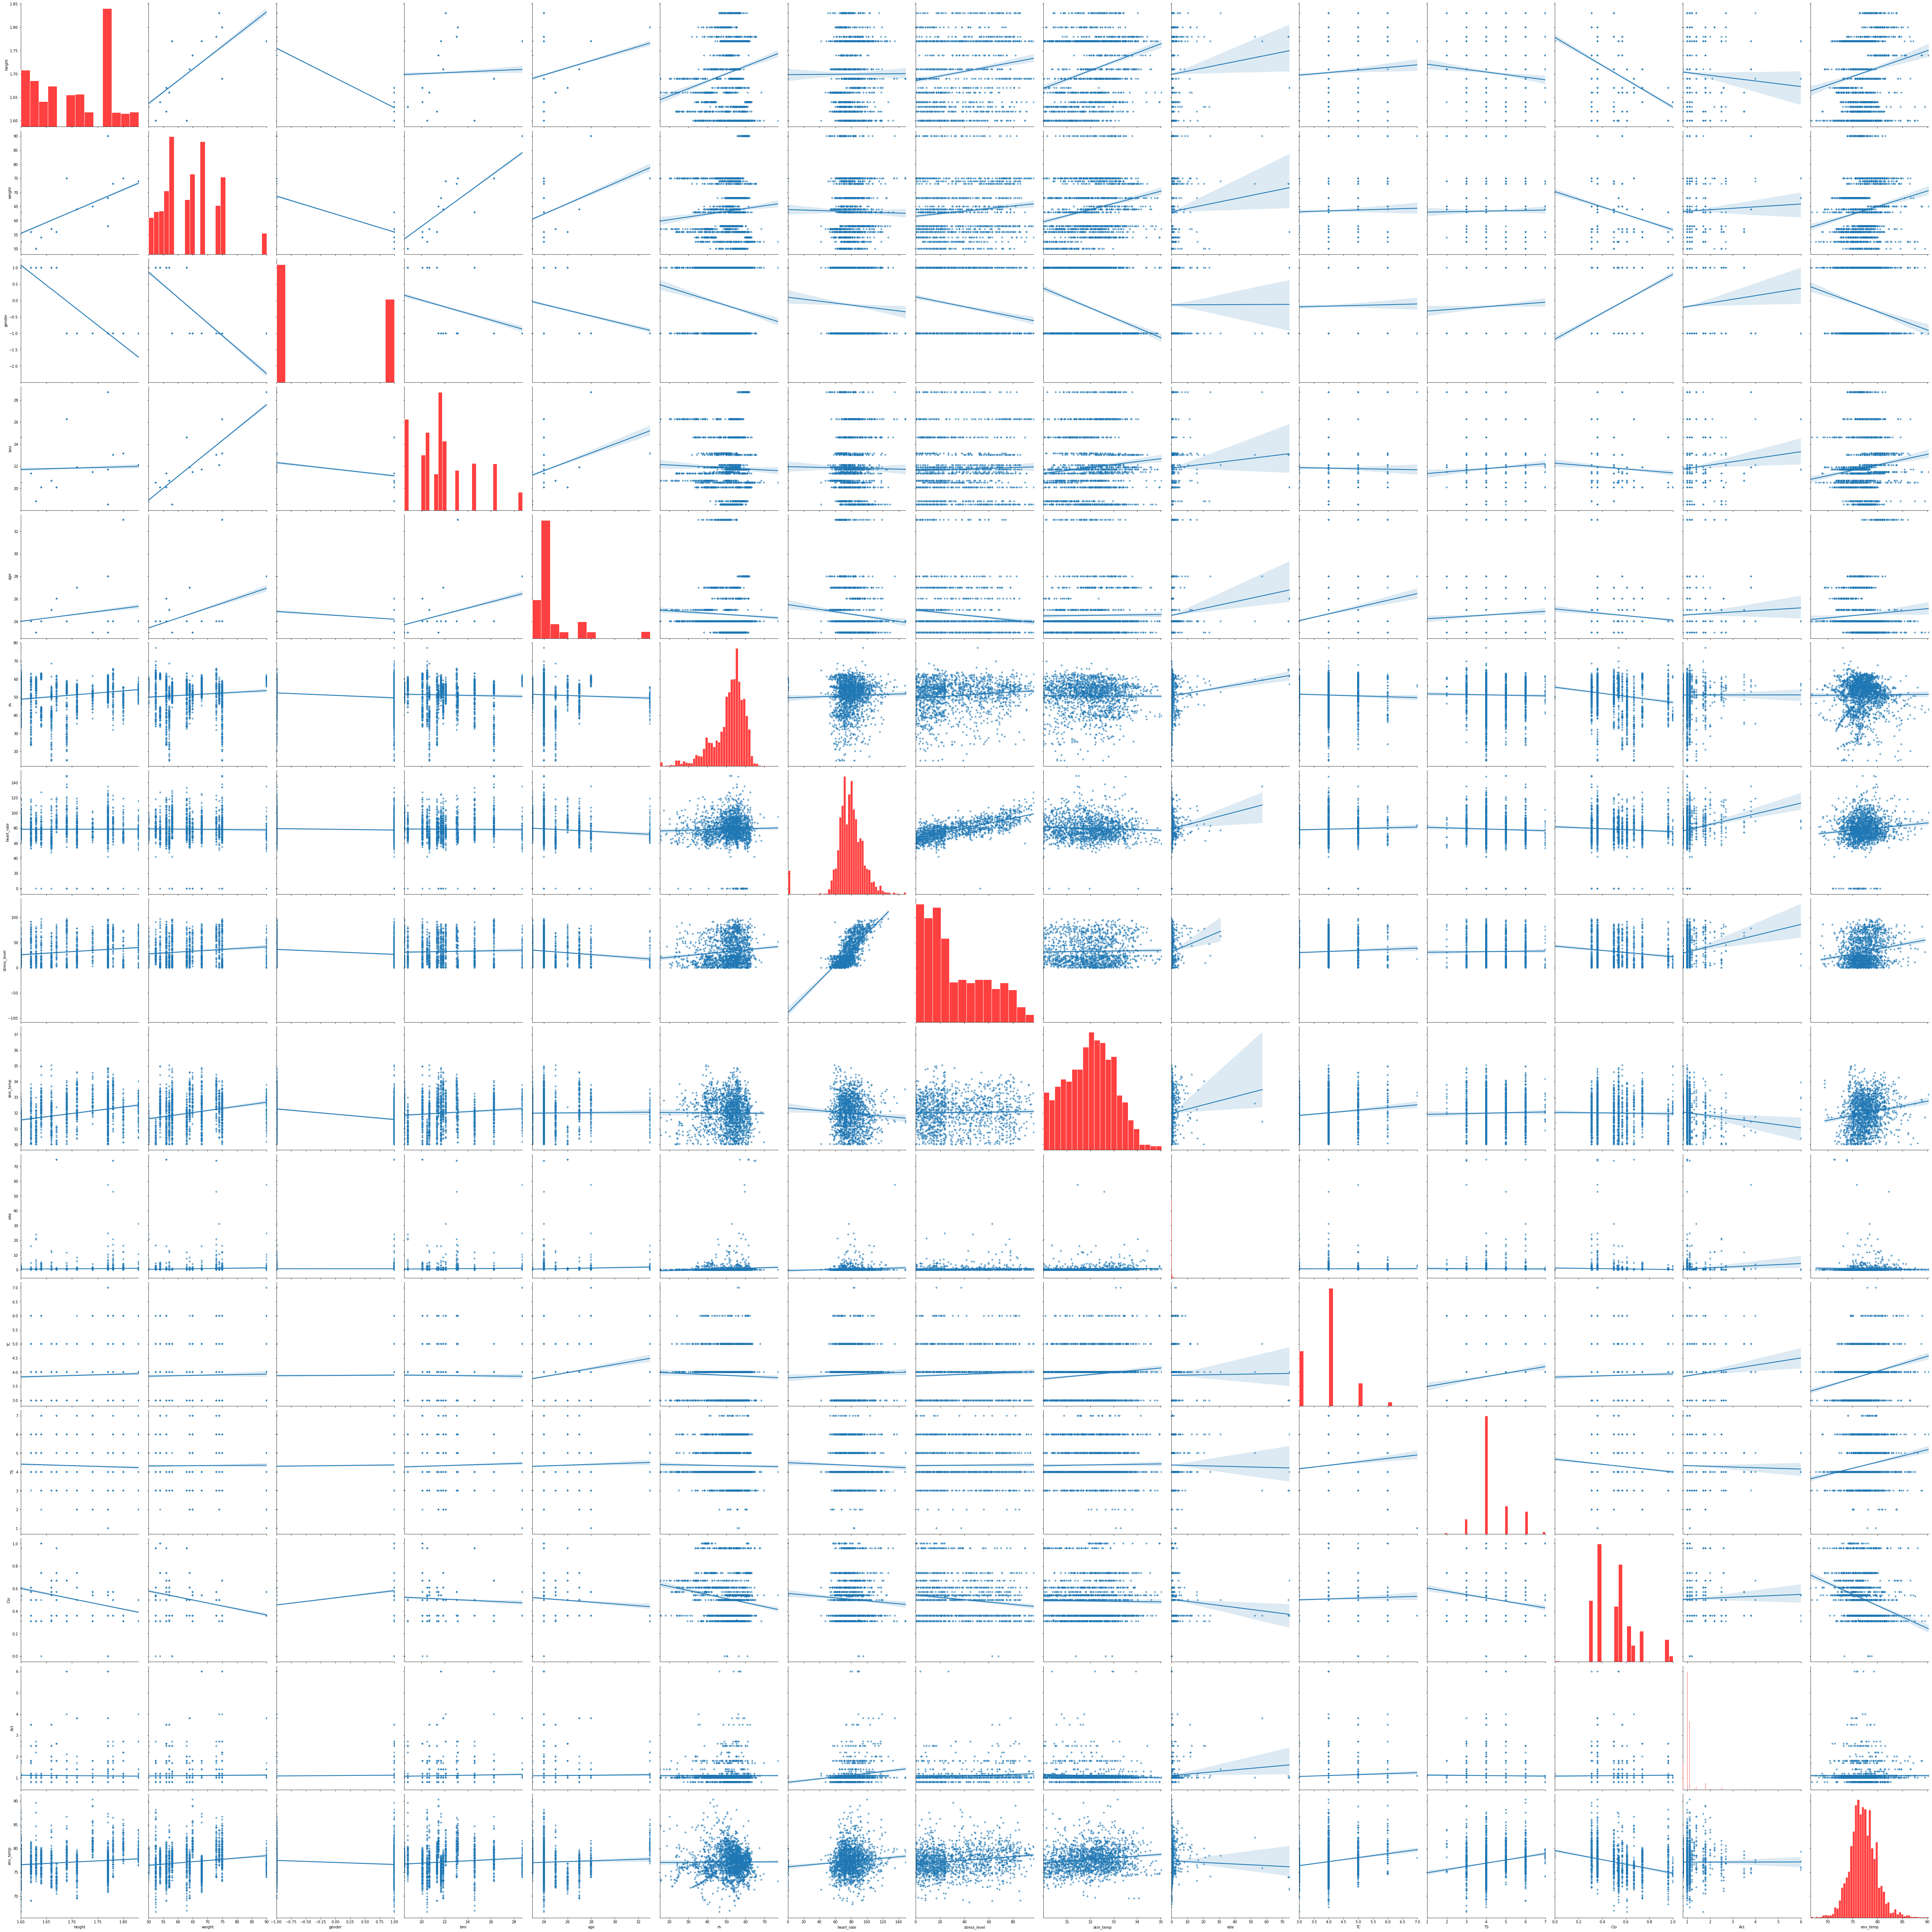

In [13]:
sns.pairplot(df_visual, dropna=True, kind='reg', markers='+', height=5, aspect=1,
            diag_kws=dict(edgecolor="w", color="r"))

#### correlation map

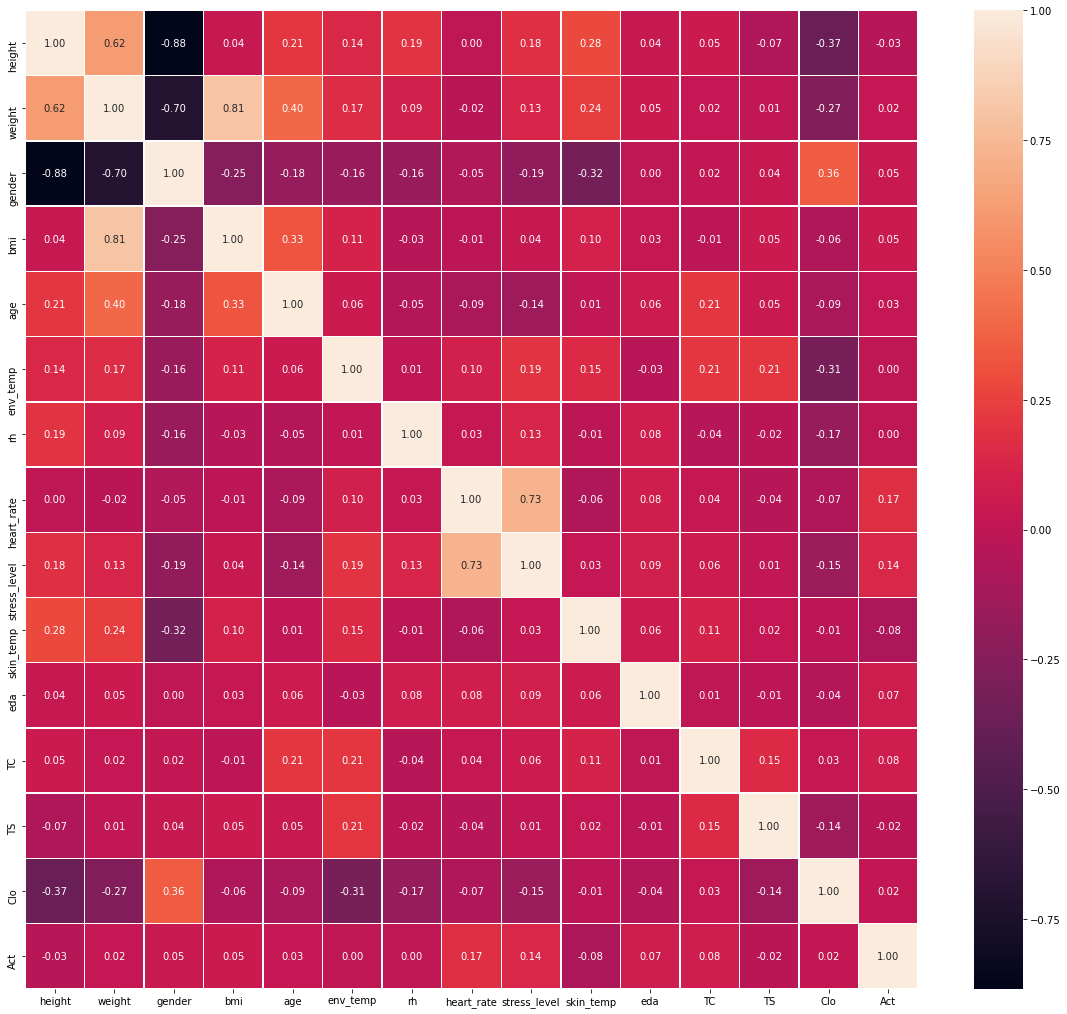

In [14]:
# correlation map
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(df_comfort.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### shuffle

In [15]:
df_shuffle = df_comfort.sample(frac=1, random_state=1208).reset_index(drop=True)

In [16]:
X_data = df_shuffle[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'TC', 'TS', 'Clo', 'Act']]

In [17]:
X_cols_name = X_data.columns

In [18]:
y_data = df_shuffle['env_temp']

### imputation

In [19]:
df_record[df_record[['env_temp']].isna().env_temp]
# no na in env_temp

Empty DataFrame
Columns: [time, height, weight, gender, bmi, age, env_temp, rh, heart_rate, stress_level, skin_temp, eda, TC, TS, Clo, Act]
Index: []

In [20]:
imp = SimpleImputer(strategy='mean')

In [21]:
X_data = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

In [22]:
X_data

height  weight  gender        bmi   age      rh  heart_rate  \
0       1.60    52.5     1.0  20.507812  24.0  62.985   83.000000   
1       1.77    58.0    -1.0  18.513199  23.0  48.702   79.000000   
2       1.71    64.0    -1.0  21.887076  27.0  47.990   79.500000   
3       1.77    58.0    -1.0  18.513199  23.0  52.445   92.000000   
4       1.77    58.0    -1.0  18.513199  23.0  56.396   78.435828   
...      ...     ...     ...        ...   ...     ...         ...   
2523    1.66    57.0     1.0  20.685150  25.0  52.940   61.000000   
2524    1.69    75.0    -1.0  26.259585  24.0  47.010   78.435828   
2525    1.60    63.0     1.0  24.609375  24.0  45.760  105.000000   
2526    1.74    65.0    -1.0  21.469150  23.0  53.640   78.435828   
2527    1.60    52.5     1.0  20.507812  24.0  52.443   75.000000   

      stress_level  skin_temp       eda   TC   TS   Clo  Act  
0        19.500000  32.003449  0.176971  4.0  4.0  0.61  1.1  
1         2.000000  30.933000  0.038822  4.0  4.0  0.36  1.1  
2        33.000000  33.199000  0.475946  4.0  4.0  0.61  1.0  
3        53.000000  30.431000  0.009852  4.0  4.0  0.36  1.0  
4        80.000000  30.087000  0.003597  4.0  4.0  0.36  1.0  
...            ...        ...       ...  ...  ...   ...  ...  
2523      2.000000  30.854000  0.008716  4.0  4.0  0.54  1.0  
2524     32.111013  31.300000  0.025626  3.0  4.0  0.36  1.0  
2525     32.111013  32.003449  0.013018  4.0  4.0  0.50  1.1  
2526     32.111013  34.150000  0.131368  4.0  7.0  0.54  0.8  
2527     20.000000  30.669000  0.046915  4.0  4.0  0.96  1.1  

[2528 rows x 14 columns]

### normalize

In [23]:
X_array_normalize, X_norm = normalize(X_data, axis=0, return_norm=True)

In [24]:
X_data = pd.DataFrame(X_array_normalize, columns=X_cols_name)

In [25]:
X_data

height    weight    gender       bmi       age        rh  heart_rate  \
0     0.018674  0.016305  0.019889  0.018573  0.019347  0.024127    0.020630   
1     0.020659  0.018013 -0.019889  0.016766  0.018541  0.018656    0.019635   
2     0.019958  0.019877 -0.019889  0.019822  0.021765  0.018383    0.019760   
3     0.020659  0.018013 -0.019889  0.016766  0.018541  0.020090    0.022867   
4     0.020659  0.018013 -0.019889  0.016766  0.018541  0.021603    0.019495   
...        ...       ...       ...       ...       ...       ...         ...   
2523  0.019375  0.017703  0.019889  0.018733  0.020153  0.020279    0.015161   
2524  0.019725  0.023293 -0.019889  0.023782  0.019347  0.018008    0.019495   
2525  0.018674  0.019566  0.019889  0.022287  0.019347  0.017529    0.026098   
2526  0.020308  0.020188 -0.019889  0.019443  0.018541  0.020548    0.019495   
2527  0.018674  0.016305  0.019889  0.018573  0.019347  0.020089    0.018641   

      stress_level  skin_temp       eda        TC        TS       Clo  \
0         0.010107   0.019882  0.000866  0.020182  0.018018  0.022576   
1         0.001037   0.019217  0.000190  0.020182  0.018018  0.013323   
2         0.017104   0.020624  0.002329  0.020182  0.018018  0.022576   
3         0.027470   0.018905  0.000048  0.020182  0.018018  0.013323   
4         0.041464   0.018691  0.000018  0.020182  0.018018  0.013323   
...            ...        ...       ...       ...       ...       ...   
2523      0.001037   0.019168  0.000043  0.020182  0.018018  0.019985   
2524      0.016643   0.019445  0.000125  0.015137  0.018018  0.013323   
2525      0.016643   0.019882  0.000064  0.020182  0.018018  0.018505   
2526      0.016643   0.021215  0.000643  0.020182  0.031532  0.019985   
2527      0.010366   0.019053  0.000230  0.020182  0.018018  0.035529   

           Act  
0     0.018588  
1     0.018588  
2     0.016898  
3     0.016898  
4     0.016898  
...        ...  
2523  0.016898  
2524  0.016898  
2525  0.018588  
2526  0.013519  
2527  0.018588  

[2528 rows x 14 columns]

In [26]:
X_norm

array([  85.67889413, 3219.80907819,   50.27922036, 1104.20171125,
       1240.52690418, 2610.52082164, 4023.35271413, 1929.40521588,
       1609.69440491,  204.39639127,  198.19434906,  221.99549545,
         27.02021465,   59.17786748])

### split: train & test

In [27]:
def split_into_train_test(X, y, frac=0.8):
    n_rows = y.shape[0]
    n_rows_train = int(n_rows * frac)
    # n_rows_test = n_rows - n_rows_train

    X_train = X[:n_rows_train]
    y_train = y[:n_rows_train]

    X_test = X[n_rows_train:]
    y_test = y[n_rows_train:]
    return X_train, y_train, X_test, y_test

In [28]:
n_rows = y_data.shape[0]

In [29]:
train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

In [30]:
X_train = X_data[:n_rows_train]
y_train = y_data[:n_rows_train]

In [31]:
X_test = X_data[n_rows_train:]
y_test = y_data[n_rows_train:]

## linear regression (1st try)

### single linear regression
env_temp = f(each feature individually)

In [32]:
n_features = X_train.shape[1]

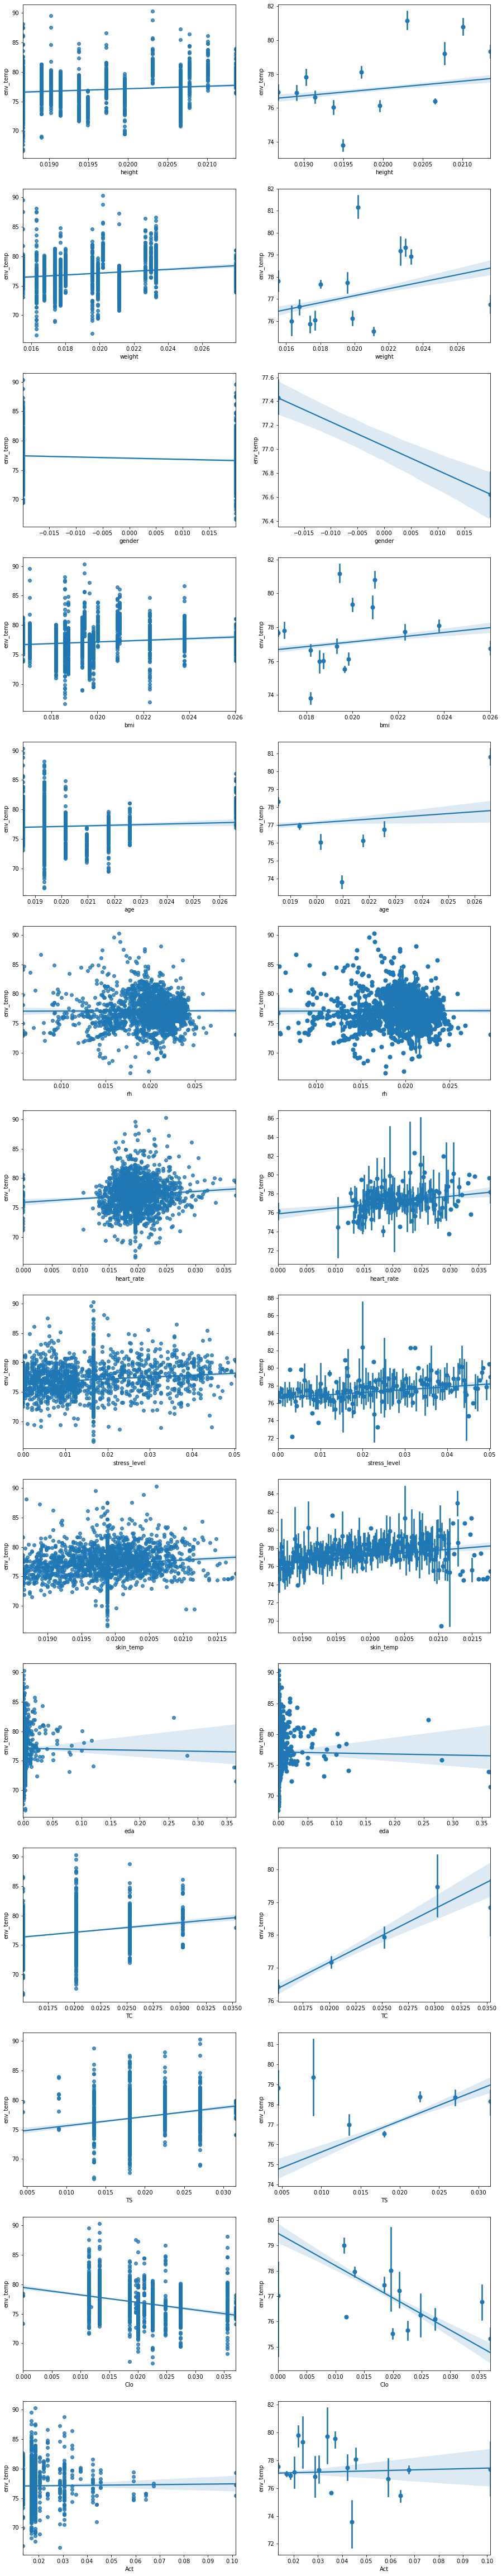

In [33]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression
env_temp = f(all features together)

In [34]:
regr = sm.OLS(y_train, X_train)

In [35]:
regr_fit = regr.fit()

In [36]:
y_pred = regr_fit.predict(X_test)

In [37]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Actual  Predicted
2022  80.029  79.721724
2023  78.449  77.532428
2024  77.050  77.601500
2025  77.574  77.732746
2026  77.923  77.604871
...      ...        ...
2523  76.703  76.117780
2524  75.484  77.200802
2525  71.683  78.011914
2526  79.151  79.034869
2527  86.211  74.157599

[506 rows x 2 columns]

In [38]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.456e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:37:09   Log-Likelihood:                         -4656.0
No. Observations:                2022   AIC:                                      9340.
Df Residuals:                    2008   BIC:                                      9419.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3121.0442    114.339     27.297      0.000    2896.810    3345.279
weight       -1450.7574     90.790    -15.979      0.000   -1628.809   -1272.705
gender          12.0220      6.382      1.884      0.060      -0.494      24.538
bmi           1575.9473     84.396     18.673      0.000    1410.435    1741.459
age            -11.3879     39.876     -0.286      0.775     -89.591      66.815
rh             -21.0134     17.083     -1.230      0.219     -54.516      12.489
heart_rate      31.2732     15.743      1.986      0.047       0.398      62.148
stress_level    17.4004      5.650      3.080      0.002       6.320      28.480
skin_temp      469.7032    106.056      4.429      0.000     261.712     677.695
eda             -4.6602      3.006     -1.550      0.121     -10.556       1.236
TC             145.1069     16.430      8.832      0.000     112.885     177.329
TS             117.1313     14.542      8.054      0.000      88.612     145.651
Clo           -114.2542      9.218    -12.394      0.000    -132.333     -96.176
Act             -1.5069      8.473     -0.178      0.859     -18.124      15.110
==============================================================================
Omnibus:                      225.344   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              747.834
Skew:                           0.545   Prob(JB):                    4.07e-163
Kurtosis:                       5.773   Cond. No.                         217.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# mean squared error
mean_squared_error(y_test, y_pred)

6.4546776853943975

In [40]:
# R2 score
r2_score(y_test, y_pred)

0.17718024785534514

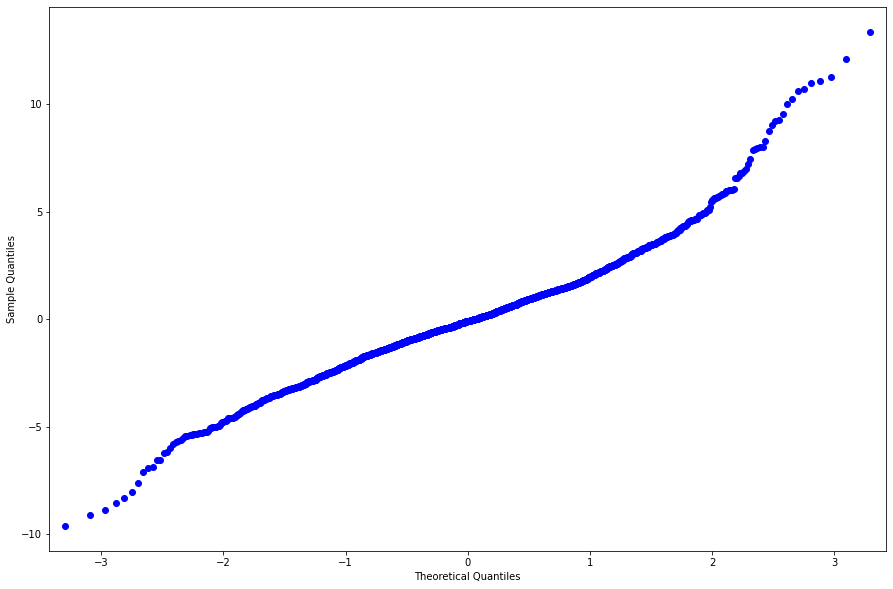

In [41]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.qqplot(regr_fit.resid)
plt.show()

## refine data

In [42]:
regr = sm.OLS(y_data, X_data)
regr_fit = regr.fit()

### leverage & outlier

In [43]:
infl = regr_fit.get_influence()

In [44]:
# leverage
leviers = infl.hat_matrix_diag
# list(leviers)

In [45]:
# studentized residue
res_studs = infl.resid_studentized_external
# list(res_studs)

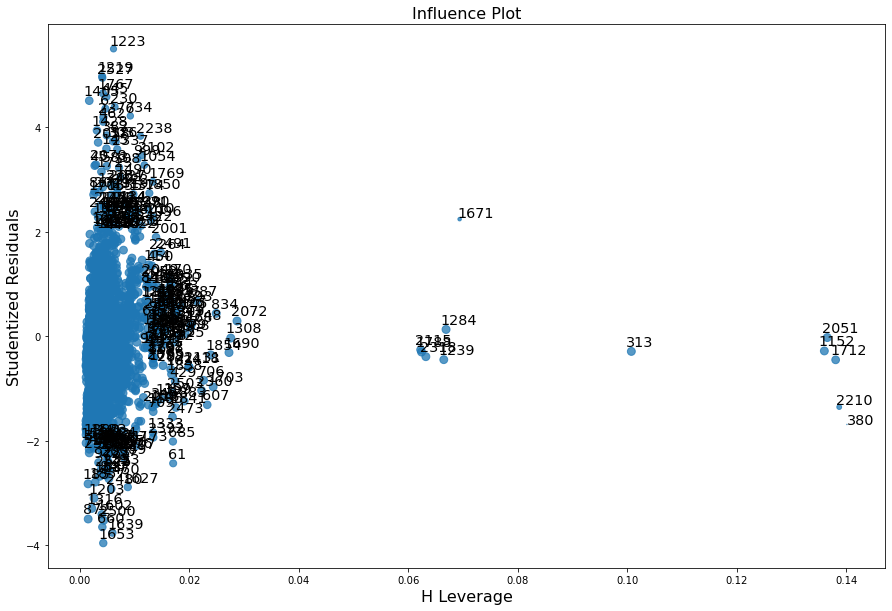

In [46]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.graphics.influence_plot(regr_fit, size=0.5)
plt.show()

### leverage detection
the threshold value may be:
$$s_h=2\times \frac{p+1}{n}$$

In [47]:
n_data = X_data.shape[0]
p_data = X_data.shape[1]

In [48]:
s_h = 2 * (p_data + 1) / n_data
s_h

0.011867088607594937

In [49]:
atyp_levier = leviers > s_h

In [50]:
X_data.index[atyp_levier]

Int64Index([  31,   61,  112,  114,  119,  135,  154,  157,  159,  168,
            ...
            2356, 2360, 2392, 2427, 2437, 2449, 2473, 2479, 2491, 2503],
           dtype='int64', length=125)

In [51]:
leviers[atyp_levier]

array([0.01335335, 0.01701877, 0.0148632 , 0.01256525, 0.01339082,
       0.01656856, 0.01340141, 0.01626871, 0.01381719, 0.02020467,
       0.01639586, 0.01325714, 0.01414791, 0.01275   , 0.01517555,
       0.10070371, 0.01395019, 0.14007615, 0.01249645, 0.01740482,
       0.01490797, 0.01314428, 0.01427868, 0.01513274, 0.01412555,
       0.02324523, 0.01235011, 0.01697338, 0.01506348, 0.02258416,
       0.01337939, 0.01919856, 0.0213444 , 0.02488305, 0.01213718,
       0.01352784, 0.01351322, 0.01501454, 0.01903472, 0.01350894,
       0.01383489, 0.01188684, 0.0177084 , 0.01658901, 0.01511554,
       0.01295075, 0.01246748, 0.01532637, 0.13595534, 0.01327087,
       0.01200204, 0.06644809, 0.01666853, 0.0160699 , 0.01512758,
       0.06686112, 0.01327447, 0.01329439, 0.01434367, 0.02753838,
       0.01720874, 0.01335327, 0.01547864, 0.01388176, 0.01482047,
       0.01984512, 0.01526832, 0.01311449, 0.01242493, 0.01399158,
       0.01324641, 0.01231794, 0.06933919, 0.02721719, 0.02432

In [52]:
len(leviers[atyp_levier])

125

### outlier detection
Threshold:
$$s_t=t_{1-0.05/2}(n-p-2)$$

In [53]:
seuil_stud = scipy.stats.t.ppf(0.975, df=n_data-p_data-2)
seuil_stud

1.9609088074865402

In [54]:
atyp_stud = np.abs(res_studs) > seuil_stud
atyp_stud

array([False, False, False, ...,  True, False,  True])

In [55]:
X_data.index[atyp_stud]

Int64Index([   6,   45,   61,   86,  106,  108,  129,  134,  144,  145,
            ...
            2442, 2450, 2460, 2476, 2480, 2484, 2486, 2500, 2525, 2527],
           dtype='int64', length=136)

In [56]:
res_studs[atyp_stud]

array([ 4.35866389,  3.26958761, -2.4280959 ,  2.7756145 ,  2.30408934,
        3.23164901, -2.5195852 ,  2.51428433, -2.05485261,  3.59474564,
       -2.03849062,  3.73075512, -2.82036604,  2.10344914,  2.287273  ,
        4.39297398,  2.31443226,  2.02594618, -2.22740641, -2.39321348,
       -2.05185413,  3.73292525, -1.9786609 , -2.06786561,  3.84820661,
        2.4256822 ,  2.32242371,  1.96339829,  4.58522336,  2.36692675,
       -2.18651029,  4.11040863, -2.13901064, -2.56155752, -2.2189978 ,
       -2.217551  ,  3.26113813, -2.02770094,  1.99964567, -2.01333837,
       -2.22361503, -3.64677428, -2.0097617 , -2.32726628, -2.15742831,
        4.2208544 , -2.0615222 ,  2.31952321,  2.01454991, -2.65713061,
       -3.49416225, -2.17085545, -2.41367335,  3.39260638,  2.05537383,
        3.28051282,  2.08629476,  2.2157433 , -2.07681356, -2.09176074,
       -3.0957377 , -2.24211022,  4.97921338,  5.5035848 , -3.29206294,
        2.85698779,  2.72260026,  1.98235801,  4.51307482,  3.94

In [57]:
len(res_studs[atyp_stud])

136

In [58]:
idx_eliminate_lvg_outl = np.logical_not(np.logical_or(atyp_levier, atyp_stud))

In [59]:
X_data.index[idx_eliminate_lvg_outl]

Int64Index([   0,    1,    2,    3,    4,    5,    7,    8,    9,   10,
            ...
            2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2526],
           dtype='int64', length=2275)

In [60]:
X_data_refine = X_data[idx_eliminate_lvg_outl]
y_data_refine = y_data[idx_eliminate_lvg_outl]

## linear regression (2nd try)

In [61]:
n_rows = y_data_refine.shape[0]

train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

X_train = X_data_refine[:n_rows_train]
y_train = y_data_refine[:n_rows_train]

X_test = X_data_refine[n_rows_train:]
y_test = y_data_refine[n_rows_train:]

In [62]:
regr = sm.OLS(y_train, X_train)

In [63]:
regr_fit = regr.fit()

In [64]:
y_pred = regr_fit.predict(X_test)

In [65]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Actual  Predicted
2015  77.117  76.680969
2016  80.735  79.574890
2017  76.507  77.547051
2019  78.624  78.905926
2020  78.800  78.607931
...      ...        ...
2521  74.467  77.036394
2522  73.753  75.698737
2523  76.703  76.192023
2524  75.484  77.130242
2526  79.151  79.222880

[455 rows x 2 columns]

In [66]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.173e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:37:18   Log-Likelihood:                         -3727.9
No. Observations:                1820   AIC:                                      7484.
Df Residuals:                    1806   BIC:                                      7561.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3119.5482     97.193     32.096      0.000    2928.925    3310.171
weight       -1588.4247     76.852    -20.669      0.000   -1739.152   -1437.697
gender           9.1800      5.273      1.741      0.082      -1.161      19.521
bmi           1679.1459     71.164     23.596      0.000    1539.574    1818.718
age            -26.5498     34.487     -0.770      0.441     -94.188      41.089
rh              24.0689     14.457      1.665      0.096      -4.286      52.424
heart_rate     -10.8883     19.080     -0.571      0.568     -48.310      26.533
stress_level    21.6332      5.045      4.288      0.000      11.739      31.527
skin_temp      524.4294     87.578      5.988      0.000     352.664     696.195
eda             -5.7990      8.162     -0.710      0.478     -21.808      10.210
TC             113.7799     14.551      7.819      0.000      85.241     142.319
TS             135.1986     12.646     10.691      0.000     110.396     160.002
Clo           -118.0080      7.759    -15.210      0.000    -133.225    -102.791
Act             -0.1702     11.039     -0.015      0.988     -21.820      21.480
==============================================================================
Omnibus:                        4.151   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                4.130
Skew:                           0.096   Prob(JB):                        0.127
Kurtosis:                       2.867   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# mean squared error
mean_squared_error(y_test, y_pred)

3.44180915221591

In [68]:
# R2 score
r2_score(y_test, y_pred)

0.30609731413573993

notice that:
- MSE clearly drops.
- R2 increases a little.
- In p-value table, featrues gender, rh, eda drops a lot; features age, heart rate increases a little.

## feature selection

### correlation map for refine data

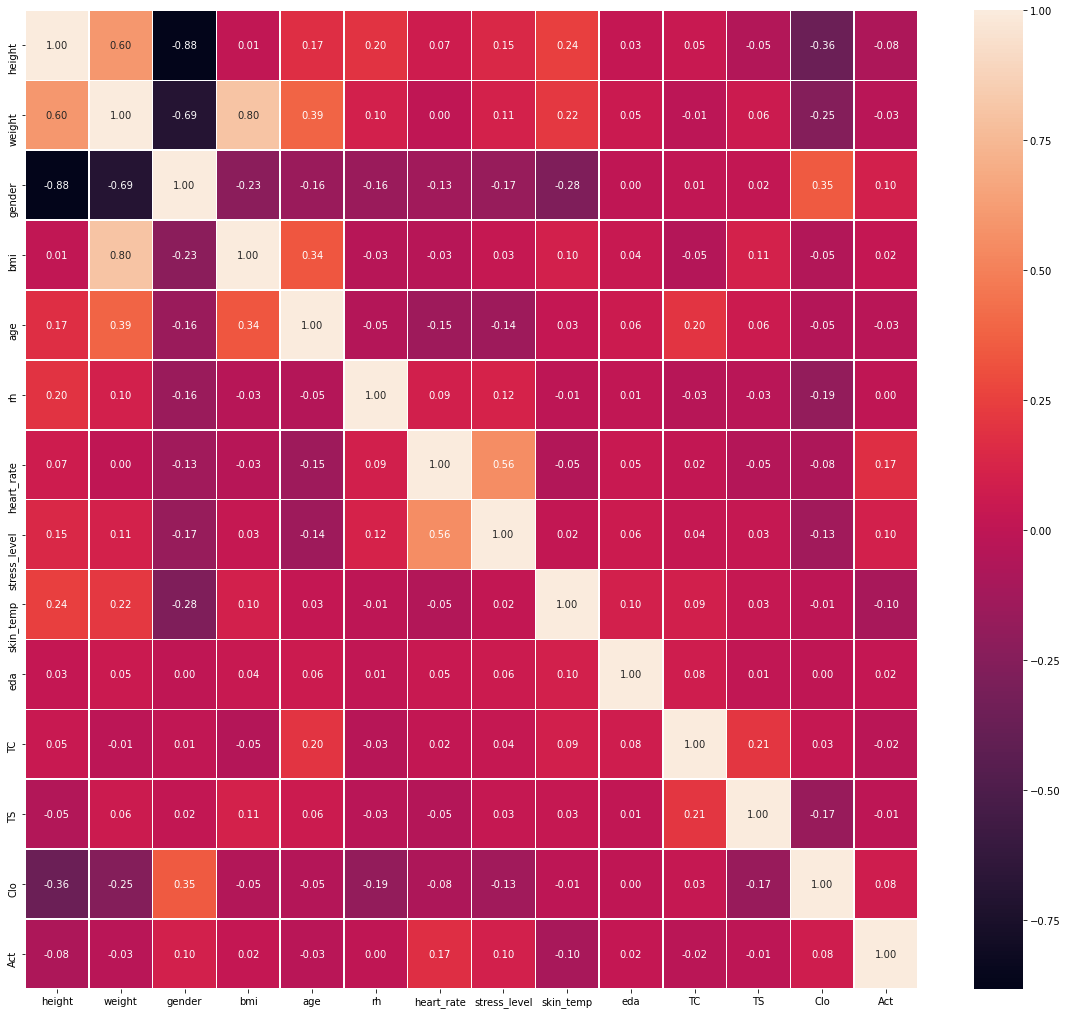

In [69]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_data_refine.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### backward selection

In [70]:
regr = sm.OLS(y_data_refine, X_data_refine)
regr_fit = regr.fit()

In [71]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.743e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:37:34   Log-Likelihood:                         -4650.7
No. Observations:                2275   AIC:                                      9329.
Df Residuals:                    2261   BIC:                                      9410.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3156.4007     86.299     36.575      0.000    2987.168    3325.633
weight       -1600.4649     68.492    -23.367      0.000   -1734.779   -1466.151
gender           8.0024      4.661      1.717      0.086      -1.138      17.143
bmi           1685.4500     63.125     26.700      0.000    1561.660    1809.240
age            -26.6331     30.860     -0.863      0.388     -87.150      33.883
rh              30.6710     12.794      2.397      0.017       5.582      55.760
heart_rate     -34.9514     16.885     -2.070      0.039     -68.063      -1.840
stress_level    27.3591      4.439      6.163      0.000      18.654      36.065
skin_temp      525.0952     77.703      6.758      0.000     372.719     677.471
eda              5.0463      7.424      0.680      0.497      -9.512      19.604
TC             110.7185     13.049      8.485      0.000      85.129     136.308
TS             126.6281     11.194     11.312      0.000     104.676     148.580
Clo           -120.6911      6.882    -17.538      0.000    -134.186    -107.196
Act             -7.5744      9.552     -0.793      0.428     -26.307      11.158
==============================================================================
Omnibus:                        6.139   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.120
Skew:                           0.111   Prob(JB):                       0.0469
Kurtosis:                       2.878   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
X_rm = X_data_refine

start to remove features

#### remove eda

In [73]:
X_rm = X_rm.drop(columns='eda')

In [74]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.955e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:37:53   Log-Likelihood:                         -4650.9
No. Observations:                2275   AIC:                                      9328.
Df Residuals:                    2262   BIC:                                      9402.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3148.6309     85.528     36.814      0.000    2980.909    3316.352
weight       -1593.4875     67.711    -23.534      0.000   -1726.269   -1460.706
gender           8.3081      4.639      1.791      0.073      -0.789      17.405
bmi           1679.3536     62.478     26.879      0.000    1556.834    1801.873
age            -26.0837     30.846     -0.846      0.398     -86.572      34.405
rh              30.7029     12.792      2.400      0.016       5.617      55.788
heart_rate     -34.3945     16.863     -2.040      0.042     -67.463      -1.326
stress_level    27.4596      4.436      6.190      0.000      18.760      36.159
skin_temp      530.8685     77.228      6.874      0.000     379.424     682.313
TC             111.1805     13.030      8.533      0.000      85.629     136.732
TS             126.5300     11.192     11.305      0.000     104.582     148.478
Clo           -120.6773      6.881    -17.538      0.000    -134.171    -107.184
Act             -7.4955      9.551     -0.785      0.433     -26.224      11.233
==============================================================================
Omnibus:                        6.251   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.231
Skew:                           0.112   Prob(JB):                       0.0444
Kurtosis:                       2.877   Cond. No.                         220.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove Act

In [75]:
X_rm = X_rm.drop(columns='Act')

In [76]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.202e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:38:41   Log-Likelihood:                         -4651.2
No. Observations:                2275   AIC:                                      9326.
Df Residuals:                    2263   BIC:                                      9395.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3141.5228     85.040     36.942      0.000    2974.758    3308.287
weight       -1594.3713     67.696    -23.552      0.000   -1727.123   -1461.620
gender           7.8070      4.594      1.699      0.089      -1.202      16.816
bmi           1678.6575     62.466     26.873      0.000    1556.161    1801.154
age            -25.8171     30.841     -0.837      0.403     -86.297      34.663
rh              30.6677     12.791      2.398      0.017       5.584      55.751
heart_rate     -36.5184     16.643     -2.194      0.028     -69.156      -3.881
stress_level    27.4211      4.436      6.182      0.000      18.723      36.120
skin_temp      534.7960     77.059      6.940      0.000     383.682     685.910
TC             111.4974     13.022      8.562      0.000      85.960     137.035
TS             126.3490     11.189     11.293      0.000     104.408     148.290
Clo           -121.0701      6.862    -17.644      0.000    -134.527    -107.614
==============================================================================
Omnibus:                        6.256   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.233
Skew:                           0.112   Prob(JB):                       0.0443
Kurtosis:                       2.876   Cond. No.                         212.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove age

In [77]:
X_rm = X_rm.drop(columns='age')

In [78]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.493e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:39:36   Log-Likelihood:                         -4651.6
No. Observations:                2275   AIC:                                      9325.
Df Residuals:                    2264   BIC:                                      9388.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3122.5100     81.945     38.105      0.000    2961.814    3283.206
weight       -1598.1831     67.538    -23.664      0.000   -1730.625   -1465.741
gender           7.0308      4.499      1.563      0.118      -1.792      15.854
bmi           1674.7297     62.285     26.888      0.000    1552.587    1796.872
rh              31.2427     12.772      2.446      0.015       6.197      56.288
heart_rate     -36.1820     16.637     -2.175      0.030     -68.808      -3.556
stress_level    27.9472      4.391      6.365      0.000      19.337      36.557
skin_temp      536.7229     77.019      6.969      0.000     385.687     687.759
TC             109.1103     12.706      8.588      0.000      84.195     134.026
TS             126.3230     11.188     11.291      0.000     104.384     148.263
Clo           -121.1119      6.861    -17.651      0.000    -134.567    -107.657
==============================================================================
Omnibus:                        5.900   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.859
Skew:                           0.107   Prob(JB):                       0.0534
Kurtosis:                       2.872   Cond. No.                         200.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove gender

In [79]:
X_rm = X_rm.drop(columns='gender')

In [80]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.840e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:40:03   Log-Likelihood:                         -4652.8
No. Observations:                2275   AIC:                                      9326.
Df Residuals:                    2265   BIC:                                      9383.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3140.7663     81.134     38.711      0.000    2981.662    3299.871
weight       -1678.7101     43.668    -38.442      0.000   -1764.344   -1593.076
bmi           1742.2392     44.881     38.819      0.000    1654.227    1830.251
rh              32.8291     12.735      2.578      0.010       7.855      57.803
heart_rate     -40.8119     16.376     -2.492      0.013     -72.926      -8.698
stress_level    28.0364      4.392      6.384      0.000      19.424      36.648
skin_temp      529.2686     76.896      6.883      0.000     378.474     680.063
TC             111.1921     12.639      8.797      0.000      86.406     135.978
TS             126.8577     11.186     11.341      0.000     104.922     148.794
Clo           -120.1319      6.835    -17.577      0.000    -133.535    -106.729
==============================================================================
Omnibus:                        7.733   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.746
Skew:                           0.131   Prob(JB):                       0.0208
Kurtosis:                       2.883   Cond. No.                         187.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### correlation map for selected data

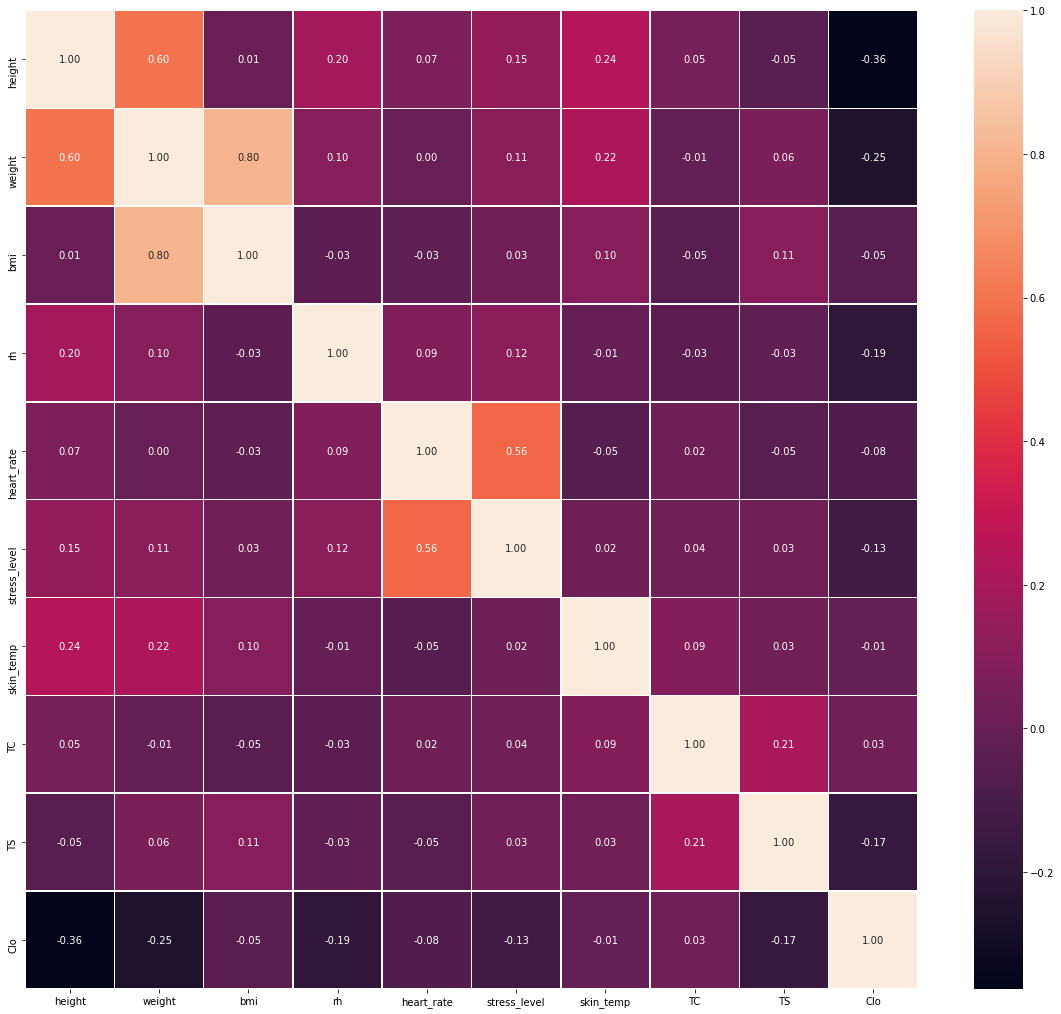

In [81]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_rm.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

## linear regression (3rd try)

### single linear regression

In [82]:
X_train, y_train, X_test, y_test = split_into_train_test(X_rm, y_data_refine)

In [83]:
n_features = X_train.shape[1]

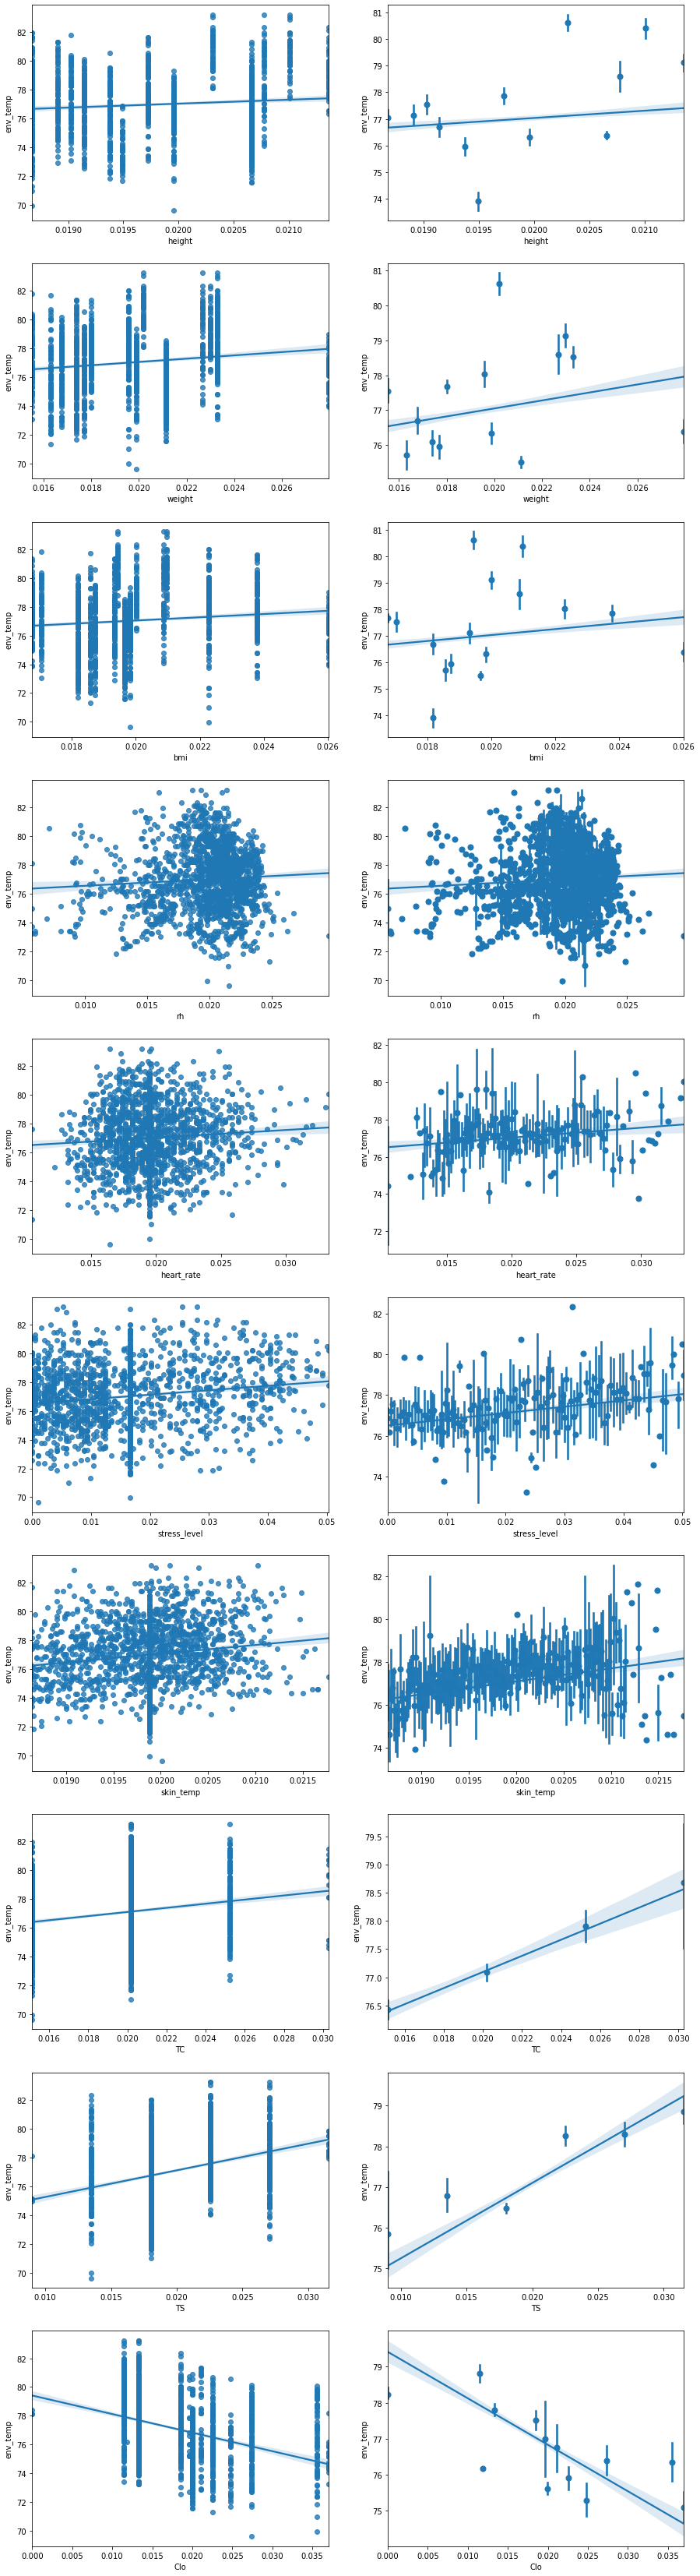

In [84]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression

In [85]:
regr = sm.OLS(y_train, X_train)

In [86]:
regr_fit = regr.fit()

In [87]:
y_pred = regr_fit.predict(X_test)

In [88]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Actual  Predicted
2015  77.117  76.671744
2016  80.735  79.641650
2017  76.507  77.535515
2019  78.624  78.980567
2020  78.800  78.780763
...      ...        ...
2521  74.467  76.923202
2522  73.753  75.901598
2523  76.703  76.121436
2524  75.484  77.204724
2526  79.151  79.257523

[455 rows x 2 columns]

In [89]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.043e+05
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                        00:41:23   Log-Likelihood:                         -3729.7
No. Observations:                1820   AIC:                                      7479.
Df Residuals:                    1810   BIC:                                      7535.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3127.7786     91.099     34.334      0.000    2949.109    3306.449
weight       -1690.9584     48.976    -34.526      0.000   -1787.014   -1594.902
bmi           1758.0211     50.372     34.901      0.000    1659.227    1856.815
rh              26.0227     14.404      1.807      0.071      -2.228      54.273
heart_rate     -16.9119     18.500     -0.914      0.361     -53.195      19.371
stress_level    22.2093      4.996      4.445      0.000      12.410      32.008
skin_temp      513.3239     86.697      5.921      0.000     343.287     683.361
TC             112.7584     14.082      8.007      0.000      85.140     140.377
TS             135.9659     12.631     10.765      0.000     111.194     160.738
Clo           -116.8727      7.702    -15.174      0.000    -131.978    -101.767
==============================================================================
Omnibus:                        5.201   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.222
Skew:                           0.117   Prob(JB):                       0.0735
Kurtosis:                       2.881   Cond. No.                         187.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
# mean squared error
mean_squared_error(y_test, y_pred)

3.4247064722933516

In [91]:
# R2 score
r2_score(y_test, y_pred)

0.3095453831624899

## cross validation

In [92]:
from sklearn import metrics
# metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [93]:
lr = LinearRegression()
lr_cv_mse = cross_val_score(lr, X_rm, y_data_refine, scoring='neg_mean_squared_error', cv=10)

In [94]:
lr_cv_mse

array([-3.68039466, -3.51107067, -3.15801455, -3.72732212, -4.02709079,
       -3.43402987, -3.27414618, -3.70553389, -3.53756818, -3.2850279 ])

In [95]:
np.abs(lr_cv_mse.mean())

3.5340198805151366

In [96]:
lr_cv_r2 = cross_val_score(lr, X_rm, y_data_refine, scoring='r2', cv=10)

In [97]:
lr_cv_r2.mean()

0.27505973581521126